# Reimann sums in Julia
### _Plus a tiny introduction to computer arithmetic_

Computer arithmetic differs from true arithmetic in several ways that are sometimes surprising. One difference is that for many computer languages there are minimum and maximum numbers of the type integer. When arithmetic operation gives a value that is outside these bounds, the calculation is said to _overflow_ and the result differs from its true value. 

In the Julia language, the default integer type, called a `Int64`, is stored in $64$ bits. Since each bit represents either zero or one, there are exactly $2^{64}$ distinct numbers of the type `Int64`. The largest `Int64` is $ 2^{63}-1 $ and the smallest is $- 2^{63} $. Adding one to the largest `Int64` gives rubbish; to illustrate this, we have

In [1]:
(2^63-1) + 1

-9223372036854775808

The true value of the sum is $9223372036854775808$, but this number exceeds the largest `Int64`, causing the sum to overflow. Julia doesn't issue a warning or an error for the overflow. Although the result is wrong, the result is predicable (that is, non-random). 

A workaround for integer overflow is to use integers of the type `BigInt`. The size of a `BigInt` is only limited by the computer memory. The penalty for using `BigInt` integers instead of `Int64` integers is that arithmetic on a `BigInt` is slower than arithmetic on `Int64` numbers. Using `BigInt` numbers, Julia gives the true value of the sum

In [2]:
BigInt(9223372036854775807) + 1

9223372036854775808

Julia supports rational arithmetic using numbers with `BigInt` numerators and denominators; for example, to evaluate $\sum_{k=1}^{15} \frac{1}{k} $ using `BigInt` rational numbers, we can use an array comprehension along with Julia's `sum` function: 

In [3]:
sum([ BigInt(1)//BigInt(k) for k=1:15])

1195757//360360

The operator for rational number division is //, not /. Thus replacing // with / gives a decimal approximation, not the true value of the sum:

In [4]:
sum([ BigInt(1)/BigInt(k) for k=1:15])

3.318228993228993228993228993228993228993228993228993228993228993228993228993199

The speed of arithmetic operations on `BigInt` slows with increasing number of digits. This is unlike arithmetic on `Int64` numbers where the time required to add or multiply is fixed. When doing arithmetic on `BigInt` numbers, for efficiency it's best to arrange the calculation so that initially the number of digits in numbers is small. There are amusing algorithms for numerical evaluation of the factorial function that do this. Later, we'll see an example where the order of addition and multiplication makes a big difference in the speed.

Another thing that can surprise users is that using the most common number type for a number with a decimal point, the number $0.1$ does not have an exact representation. This is due to the fact that numbers with decimal points are stored in a binary, not a decimal format. The number $0.1$ has a binary representation that repeats, much like the decimal representation of $1/3$. Thus, when the binary representation of $0.1$ is rounded to fit into computer memory, making the stored value different from the true value. 

In computer arithmetic, numbers with decimal points are called _floating point numbers_. The name comes 
from the fact that their decimal points (actually binary points) are moved (they _float_) and the 
exponent adjusted to make the stored number have the form $1 . b_1 b_2 \cdots b_n \times 2^e$, where 
each bit $b_1$ through $b_n$ is either 0 or 1 and the exponent $e$ is an integer.

__Details__ The leading bit, that is $b_0$, of a _subnormal number_ is zero. See https://en.wikipedia.org/wiki/Denormal_number .  The number of bits stored, that is the integer $n$, depends on the floating point type. The most common floating point type is binary64. A binary64 has $n=52$. In Julia, a binary64 number has the type `Float64`.

Although the floating point number that is closest to $1/10$ prints as $0.1$, the binary64 float that is nearest to $0.1$ is 
$$
   3602879701896397/36028797018963968 = 0.1000000000000000055511151 \cdots . 
$$
So the floating point number $0.1$ is a tiny bit larger than its true value.

The fact that the floating point number $0.1$ is slightly larger than $1/10$ has the consequence that 
$0.1 + 0.1 + 0.1$ doesn't equal $0.3$, and it doesn't print as $0.3$ either; instead, the sum is 

In [5]:
0.1 + 0.1 + 0.1

0.30000000000000004

Users sometimes see $0.1 + 0.1 + 0.1 = 0.30000000000000004$ and think that something has gone _terribly wrong_. Nothing has gone wrong--the result differs from the true value $0.3$ because $0.1$ has a binary representation that repeats, so regardless of the number of bits stored, the number $0.1$ doesn't have an exact binary representation.

For another example, adding $0.1 + 0.1 + \cdots + 0.1$ one million times, the rounding error accumulates giving the value $100000.00000133288$ instead of the true value of $100000.0$:


In [6]:
s = 0.0;

In [7]:
for i in 1:10^6
    s += 0.1
end
s

100000.00000133288

Starting from the true value \(100000.0\) and repeatedly subtracting \(0.1\), the final value isn't zero:

In [8]:
s = 100000.0

100000.0

In [9]:
for i in 1:10^6
    s -= 0.1
end
s

-1.3328811345469926e-6

The IEEE 2008 754 standard defines a floating point number that (effectively) is stored in a decimal, not binary format. Such numbers are ideal for working with US currency, but few languages and microprocessors have support for these decimal floating point numbers. 

Somewhat like integer overflow, floating point numbers can overflow as well. In Julia, an overflow of a floating point number results in `Inf`.  The largest number of the type `Float64` is just shy of $2^{1024}$.  Evaluating $1.999999999999999 * 2.0^{1023}$ doesn't overflow, but evaluating $2.0^{1024}$ overflows to `Inf`. The Julia number `Inf` has some of the same properties as does the number infinity.

In [10]:
1.999999999999999 * 2.0^1023

1.797693134862315e308

In [11]:
2.0^1024

Inf

Floating point numbers can _underflow._  By underflow, we mean that a nonzero number rounds to zero. The smallest positive number of the type `Float64` is just above $2^{-1075}$; thus

In [12]:
0.5000000000000001 * 2^(-1074)

5.0e-324

In [13]:
2^(-1075)

0.0

So computer arithmetic violates the fact that the product of positive numbers is positive.  

One final item that can surprise users is that addition of floating point isn't associative. This is due to the fact that adding involves adding followed by rounding the sum to the nearest number of the given type. A simple example is

In [14]:
[(10.0^16+1)-10.0^16, (10.0^16- 10.0^16) + 1]

2-element Vector{Float64}:
 0.0
 1.0

The true value of this sum is one. In the first calculation the first sum $10.0^{16}+1$ rounds to $10.0^{16}$. After that, subtracting $10.0^{16}$ gives zero. But evaluating $(10.0^{16}- 10.0^{16}) + 1$ gives the true value.

Another example

In [15]:
(0.6 + 0.05) + (0.04 + 0.03) 

0.72

In [16]:
0.6 + (0.05  + (0.04 + 0.03))

0.72

In [17]:
0.03 + (0.04  + (0.05 + 0.6))

0.7200000000000001

For the first sum $ (0.6 + 0.05) + (0.04 + 0.03) $ the terms were grouped in pairs. This is called a _pairwise sum._ For this case, the pairwise sum gives the true value of the sum. For the second sum $0.6 + (0.05  + (0.04 + 0.03))$, we added the numbers from the least to the greatest magnitude. Again for this case, adding from least to greatest magnitude also gives the true value of the sum.  The third sum $0.03 + (0.04  + (0.05 + 0.6))$, the numbers are added from the greatest to the least magnitude. This sum differs from its true value.

Adding _positive_ numbers from the least to the greatest magnitude minimizes the rounding error in the _worst case_. The worst case, of course, doesn't always happen. So It's not always true that adding positive numbers in this order always gives the best result. 

Of course, adding from least to greatest magnitude requires the overhead of sorting the numbers. If the numbers are in an array, the sort can be done easily. But if the numbers are generated one at a time, say in a loop, adding from least to greatest magnitude also requires the memory overhead of storing the numbers. 

The key to understanding these results is the machine epsilon. Assuming that a number $x$ doesn't overflow, the nearest floating point number to $x$, denoted by $\mathrm{fl}(x)$, is
$$
   \mathrm{fl(x)} = x (1+ \varepsilon), \quad |\varepsilon| \leq \varepsilon_m, 
$$
where $\varepsilon_m$ is the _machine epsilon._  The machine epsilon depends on the the number of bits in a float. For a binary64 number, we have
$$
  \varepsilon_m = 2^{-53} \approx 10^{-16}.  
$$  
The number $\varepsilon$ in the equality $\mathrm{fl(x)} = x (1+ \varepsilon)$ varies with $x$ in a way that jumps around a great deal, but it isn't random. An alternative to this equality is that for nonzero $x$, we have
$$
   \left | \frac{\mathrm{fl(x)}  - x}{x} \right| \leq \varepsilon_m. 
$$
Simply put, this says that the relative difference between $x$ and its nearest float is bounded above by the machine epsilon.

We've already shown that floating point addition isn't associative. What more can we say? Plenty. Assuming no overflow the floating point sum is the true sum rounded to the nearest float. The same is true for subtraction, multiplication, and division. Specifically, for floating point numbers $x$ and $y$, we have the simple rules
\begin{align*}
   x \oplus y &= \mathrm{fl}(x+y), \\
   x \ominus y &= \mathrm{fl}(x-y), \\
   x \otimes y &= \mathrm{fl}(x y), \\
   x \oslash y &= \mathrm{fl}(x/y).
\end{align*}



With these ideas in mind, let's write a Julia function that computes the left-point Riemann sum.  Thus, for a function $F$, an interval $[a,b]$, and a positive integer $n$, we want to sum
$$
    h \sum_{k=0}^{n-1} F(a + h k),
$$
where $h = \frac{b-a}{n}$.

We'll write several Julia language versions of this function. The first uses a pairwise sum and the second uses a loop. The method that uses the pairwise sum is particularly easy to write. All we need to do is to use Julia's array comprehension and call the Julia function `sum` on the array. Conveniently, the Julia's `sum` function uses a pairwise summation. But the fact that sum uses a pairwise algorithm isn't, as far as I can tell, mentioned in the user documentation, so it's not guaranteed that all versions of Julia use the pairwise sum.


In [18]:
function left_point_sum_pairwise(F::Function, a::Number, b::Number, n::Integer)
    h = (b-a)/n
    h*sum([F(a + h*k) for k=0:n-1])
end

left_point_sum_pairwise (generic function with 1 method)

The next version sorts the terms to be added from the least to the greatest magnitude then adds in that order. Assuming positive summands, this method minimizes the rounding error for the worst case. Of course, not all cases are the worst case and not all integrands are positive functions.

In [19]:
function left_point_sum_sorted(F::Function, a::Number, b::Number, n::Integer)
    h = (b-a)/n
    h*foldl(+, sort([F(a + h*k) for k=0:n-1], by = x-> abs(x)))
end

left_point_sum_sorted (generic function with 1 method)

Our next method generates the terms to be summed one by one and adds them in the order they are generated.

In [20]:
function left_point_sum(F::Function, a::Number, b::Number, n::Integer)
    h = (b - a) / n
    s = zero(a)
    for k in 0:n-1
        s += F(a + h * k)
    end
    h*s
end

left_point_sum (generic function with 1 method)

Instead of calculating the knots (the numbers $a, a+h, a+2h, \dots$) using $a+hk$, we could compute them faster by adding $h$ to the previous knot. Let's modify left\_point\_sum to use this method:

In [21]:
function left_point_sum_speedy(F::Function,a::Number,b::Number,n::Integer) 
   s = zero(a)
   h = (b-a)/n
   k = zero(n)
   for k in 0:n-1
        s += F(a)
        a += h
    end
    h*s
end;

Evaluating $a + h k$ involves two roundings. First, the product $h k$ is rounded to the nearest floating point number; second the sum $a + h k$ is rounded. The function `fma` (fused-multiply-and-add) accomplishes the same, but effectively only does one rounding, not two. Not all microprocessors support the `fma` instruction; for those that don't, Julia supports the `fma` instruction in software.  Here is a version that uses the `fma` instruction.

In [22]:
function left_point_sum_fma(F::Function, a::Number, b::Number, n::Integer)
    h = (b - a) / n
    s = zero(a)
    for k in 0:n-1
        s += F(fma(h,k,a))
    end
    h*s
end

left_point_sum_fma (generic function with 1 method)

Let's test these functions using rational numbers. Since all additions are exact (no rounding), each of these functions should give exactly the same value. And we expect that left\_point\_sum\_pairwise should use more memory and should likely be slower. But we'll discover that this isn't so.

In [23]:
using BenchmarkTools

In [24]:
fn = x -> 1/x;

In [25]:
a = BigInt(2)//2^8

1//128

In [26]:
b = BigInt(4)//1

4//1

In [27]:
n = BigInt(10);

In [28]:
@btime left_point_sum_pairwise(fn, a, b, n)

  24.000 μs (481 allocations: 11.91 KiB)


68189584121050611409791676271//1265129634860115172070520312

In [29]:
@btime left_point_sum(fn, a, b, n)

  23.900 μs (479 allocations: 11.76 KiB)


68189584121050611409791676271//1265129634860115172070520312

In [30]:
@btime left_point_sum_speedy(fn, a, b, n)

  19.500 μs (391 allocations: 10.16 KiB)


68189584121050611409791676271//1265129634860115172070520312

In [31]:
@btime left_point_sum_fma(fn, a, b, n)

  24.700 μs (498 allocations: 13.31 KiB)


68189584121050611409791676271//1265129634860115172070520312

In [32]:
@btime left_point_sum_sorted(fn,a,b,n)

  41.600 μs (753 allocations: 16.40 KiB)


68189584121050611409791676271//1265129634860115172070520312

Since we used rational arithmetic numbers of the type `BigInt`, we expect all of these values to be the same. They are.

 We can even be wild-and-crazy and use ten-thousand subintervals and use exact rational arithmetic. Among our methods, we might expect left\_point\_sum\_pairwise to use the most memory and be the slowest. But the evidence is that is false:

In [33]:
n = BigInt(10^4);

In [34]:
@btime left_point_sum_pairwise(fn, a, b, n);

  47.705 ms (450037 allocations: 21.96 MiB)


In [35]:
@btime left_point_sum(fn, a, b, n);

  188.982 ms (450034 allocations: 134.68 MiB)


For exact rational numbers, the method based on the pairwise sum is much faster and uses much less memory. Since the pairwise sum method stores all the values to be summed in an array, this is a mystery. The reason for the advantage of the pairwise sum method is that the speed and memory usage for `BigInt` arithmetic depends on the number of digits in the numbers. Initially, the pairwise sum method keeps the number of digits in the numbers smaller than the other methods.  This gives the pairwise sum method an advantage for `BigInt` rational numbers.


Let's try our functions using floating point arithmetic. To do this, let's convert the endpoints to `Float64` numbers and the number of subintervals to an `Int64` number.

In [36]:
a = convert(Float64,a)

0.0078125

In [37]:
b = convert(Float64,b)

4.0

In [38]:
n = convert(Int64,n);

Let's compare each to the exact value. The pairwise sum is the best; the sorted sum method is second best; and the `fma` based method is tied with the loop method for third place. Our speedy method is in last place for accuracy. Its poor accuracy shouldn't be surprising. The rounding errors for computing the knots accumulate eventually making the values differ from their true values. Is the extra speed worth the lower accuracy? Probably not.  General evaluating the integrand is the most time-consuming (expensive) task.  Optimizing the evaluation of the knots at the expense of lower accuracy is misplaced effort (see the Law of Triviality, \url{https://en.wikipedia.org/wiki/Law_of_triviality}).



In [39]:
left_point_sum_pairwise(fn,a,b,n) - exact

UndefVarError: UndefVarError: `exact` not defined

In [40]:
left_point_sum(fn,a,b,n) - exact

UndefVarError: UndefVarError: `exact` not defined

In [41]:
left_point_sum_speedy(fn, a, b, n) - exact

UndefVarError: UndefVarError: `exact` not defined

In [42]:
left_point_sum_fma(fn,a,b,n) - exact

UndefVarError: UndefVarError: `exact` not defined

In [43]:
left_point_sum_sorted(fn,a,b,n) - exact

UndefVarError: UndefVarError: `exact` not defined

Our final method uses the Kahan summation formula. This is a very tricky method that uses an approximation for the rounding errors and adds the rounding errors back into the sum. For this method to work, we must resist the urge to algebraically simplify the code. If addition was true addition, the variable $c$ would always be zero. But due to rounding, it's not. It is the value of $c$ that approximately tracks the rounding error

In [44]:
function left_point_sum_kahan(F::Function, a::Number, b::Number, n::Integer)
    s = zero(a)
    c = s
    h = (b-a)/n
    k = zero(n)
    while k < n
        y = F(fma(h,k,a))-c
        t = s + y
        c = (t-s) - y
        s = t
        k += 1
     end
    h*s
end
    

left_point_sum_kahan (generic function with 1 method)

On this problem, the Kahan summation method is better than the pairwise sum based method, but it doesn't have the overhead of storing all the values into an array. Rounded to the nearest `Float64`, the Kahan summation method gives the exact value:

In [45]:
@btime i5 = left_point_sum_kahan(fn,a,b,n) - exact

UndefVarError: UndefVarError: `exact` not defined

To use `BigFloats`, we can use the same code as for `Float64` numbers. All we need to do is use `BigFloats` for the endpoints.

In [46]:
left_point_sum_kahan(fn,convert(BigFloat, BigInt(2)//2^8),convert(BigFloat, BigInt(4)),n)

6.264042265949321880512500606122582026909991880765171984737776087179752222831425

Finally, we expect that as the number of subintervals grows to infinity, the left point sums converge to the true value of the definite integral. So a graph of the left point sum as a function of the number of subintervals should have a horizontal asymptote. A quick graph shows that this is the case:

In [47]:
using Gadfly

In [48]:
F = n -> left_point_sum(fn, a, b, convert(Int64, floor(n)));

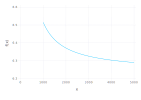

In [49]:
plot(F, 1000, 5000)


While we are at it, here is a method that averages the left and right point rules. Geometrically, the arithmetic average of the left and right point rules gives sum of areas of trapezoids. We could literally call our left point rule code and our right point rule code, but that would be inefficient--doing, so we would evaluate the function at each interior point twice. Here are a better way.

In [50]:
function trap_pairwise(F::Function, a::Number, b::Number, n::Integer)
    h = (b-a)/n
    h*(sum([F(fma(h,k,a)) for k in 1:n-1]) + F(a)/2 + F(b)/2)
end

trap_pairwise (generic function with 1 method)

In [51]:
function trap(F::Function, a::Number, b::Number, n::Int64)
    s = (F(a)+F(b))/2
    h = (b-a)/n
    for k in 1:n-1
        s += F(fma(h,k,a))
    end
    h*s
end

trap (generic function with 1 method)

A version that uses Kahan summation

In [52]:
function trap_kahan(F::Function, a::Number, b::Number, n::Int64)
    s = (F(a)+ F(b))/2
    c = zero(a)
    h = (b-a)/n
    for k in 1:n-1
        y = F(fma(h,k,a))-c
        t = s + y
        c = (t-s) - y
        s = t
    end
    h*s
end

trap_kahan (generic function with 1 method)

In [53]:
G = n -> trap_pairwise(fn, a, b, convert(Int64, floor(n)));

Graphically, the trapezoidal rule gives values that appear to converge much faster than those of the left point rule.

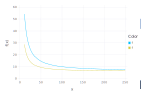

In [54]:
plot([F,G], 10, 250)

The approach of the graph toward its horizontal asymptote looks predictable. Possibly if we knew something about how the graph approaches the asymptote, we could use that information to find a good approximation for the asymptote. To this end, let's _guess_ that if $F_n$ is the left-point rule approximation using $n$ subintervals, then
$$
   F_n = L + \frac{1}{n^\alpha} (A + \mathrm{O}(1/n)),
$$
where $L$ is the true value of the definite integral and $A$ and $\alpha$ are real numbers. We shouldn't, of course, guess--in a bit we'll give a theoretical basis for this guess. To start, we have
$$
   \lim_{n \to \infty}  \frac{F_{n+1} - L}{F_n - L} = 1
$$
This says that the guess that $F_n = L + \frac{1}{n^\alpha} (A + \mathrm{O}(1/n)) $ implies that the convergence rate is _sublinear._

We can, of course, evaluate $F$, thus possibly if we evaluate $F_n = L + \frac{1}{n^\alpha} (A + \mathrm{O}(1/n)) $ for three distinct values of $n$, we can solve for $L$, $A$, and $\alpha$. The natural choice might be to choose three consecutive values of $N$. This choice gives rise to the terms $A/n^\alpha, A/(n+1)^\alpha$, and $A/(n+2)^\alpha$. Since both $A$ and $\alpha$ are unknown, using three consecutive values of $n$ gives rise to complicated equations.

As an alternative to choosing consecutive values of $n$, let's try choosing $n$ to be $2 n$ and $4 n$.
Dropping the big-oh term and replacing $n$ by $2 n$ and by $4 n$ yields the equations 
\begin{align} 
  F_n &= L  + \frac{A}{n^\alpha}, \\
  F_{2n}  &= L  + \frac{A}{2^\alpha n^\alpha}, \\
  F_{4n}  &= L  + \frac{A}{4^\alpha n^\alpha}.
\end{align} 
Solving these equations for $L, A$, and $\alpha$ gives
\begin{align} 
   L &=  \frac{2^\alpha F_{2 n} - F_n}{2^\alpha - 1}, \\
   A &=  n^\alpha \left(F_n -L\right), \\ 
   2^\alpha &= \frac{F_{2 n} - F_n}{F_{4 n} - F_{2 n}}.
\end{align}
We'll call $L$ computed this way the _extrapolated limit_. 
  
How might we best evaluate these values using floating point numbers in a way that minimizes the rounding errors?  One approach is to use the online tool Herbie http://herbie.uwplse.org/demo). To evaluate $\frac{F_{2 n} - F_n}{F_{4 n} - F_{2 n}}$, Herbie recommends
$$
 \frac{F_{2 n}}{F_{4 n} - F_{2 n}}  - \frac{F_n}{F_{4 n} - F_{2 n}}.
$$
This might seem curious--evaluating this requires two divisions and two distinct subtractions, but evaluating
$\frac{F_{2 n} - F_n}{F_{4 n} - F_{2 n}}$ requires the same number of subtractions, but one less division. For efficiency, we prefer $\frac{F_{2 n} - F_n}{F_{4 n} - F_{2 n}}$ over the recommendation of Herbie.

Replacing all floating point arithmetic by true arithmetic followed by rounding to the nearest float, we find that an upper bound for the rounding error for evaluating $ \frac{F_{2 n} - F_n}{F_{4 n} - F_{2 n}}$ is
$$
  3 \varepsilon_m \left|   \frac{F_{4 n} - F_{2 n}}{F_{4 n} - F_{2 n}} \right |
$$
Alternatively, the relative error is simply $3 \varepsilon_m $. This is a nice simple result.  But doing the same analysis on the alternative formula $\frac{F_{2 n}}{F_{4 n} - F_{2 n}}  - \frac{F_n}{F_{4 n} - F_{2 n}}$ gives the upper bound on the rounding error as
$$
2 \varepsilon_m  \left|   \frac{F_{4 n} - F_{2 n}}{F_{4 n} - F_{2 n}} \right | +
\varepsilon_m   \left|   \frac{F_{4 n}}{F_{4 n} - F_{2 n}} \right |  
+ \varepsilon_m   \left|   \frac{F_{2 n}}{F_{4 n} - F_{2 n}} \right |. 
$$
The triangle inequality shows that this upper bound is smaller than the bound for evaluating $\frac{F_{4 n} - F_{2 n}}{F_{4 n} - F_{2 n}}$. Thus, Herbie is correct: we should prefer $\frac{F_{2 n}}{F_{4 n} - F_{2 n}}  - \frac{F_n}{F_{4 n} - F_{2 n}}$ over $\frac{F_{2 n} - F_n}{F_{4 n} - F_{2 n}}$.

The strategy of minimizing the upper bound is risk avoidant. This strategy isn't always going to be the best, but it's never the worst. 

Substituting $2^\alpha \leftarrow \frac{F_{2 n} - F_n}{F_{4 n} - F_{2 n}}$ for $2^\alpha$ into the equation for $L$ gives
$$
   L =  \frac{F_n F_{4 n} - F_{2 n}^2  }{F_{4 n} - 2 F_{2 n} + F_n}.
$$
This is the well-known Aitken extrapolation https://en.wikipedia.org/wiki/Aitken%27s_delta-squared_process, except that we used the knots $F_n, F_{2 n}, F_{4 n}$ instead of $F_n, F_{n+1}, F_{n+2}$.

When $F_n \approx L, F_{n+1} \approx L$, and $F_{n+2} \approx L $, evaluating the numerator of $ - \frac{F_{2 n}^2  - F_n F_{4 n}}{F_{4 n} - F_{2 n} + F_n}$ involves subtracting two numbers that are nearly equal.  Thus, this subtraction potentially leads to subtractive cancellation. One workaround is to first compute
$$
  2^\alpha = \frac{F_{2 n} - F_n}{F_{4 n} - F_{2 n}}
$$
and then to use this value in
$$
  L =  \frac{2^\alpha F_{2 n} - F_n}{2^\alpha - 1}.
$$
Alternatively, starting from
$$
  L = \frac{F_n F_{4 n} - F_{2 n}^2}{F_{4 n} - F_{2 n} + F_n},
$$
we suspect that from among the values $F_n, F_{2 n}$, and $F_{4n}$ that $F_{4n}$ is the closest value to $L$. Subtracting $F_{4n}$ from both sides of this equation and factoring, yields
$$
  L - F_{4n} = \frac{(F_{4 n} - F_{2n})^2}{F_{4 n} - 2 F_{2 n} + F_n}.
$$
So an alternative formula for the extrapolated limit is
$$
  L  =  F_{4n} + \frac{(F_{4 n} - F_{2n})^2}{F_{4 n} - 2 F_{2 n} + F_n}.
$$
When subtractive cancellation occures in evaluating $F_{4 n} - F_{2n} $, say resulting in a value that is about the machine epsilon, that value will be squared before it is divided by the the denominator, that is also close to the machine epsilon. The end result is that the computed value of $L$ will be close to $F_{4 n}$ and the effect of the subtractive cancellation is small.

Warning: Finding the values of $L,A$, and $\alpha$ using the values of $F_n, F_{2n}$, and $F_{4n}$ is sometimes a _fool's errand_. It can happen that tiny changes to the values of $F_n, F_{2n}$, and $F_{4n}$ can cause large changes to the values of $L, A$, or $\alpha$. To illustrate, suppose
\begin{align} 
   F_{1000} &= \frac{2001}{2000}  \approx  1.0005, \\
   F_{2000} &= \frac{4001}{4000} \approx 1.00025, \\
   F_{4000} &= \frac{8001}{8000} \approx  1.000125.
\end{align}
The exact solution gives $L = 1, A = 5, \alpha = 1$.  So far, OK.  Now suppose
\begin{align} 
   F_{1000} &= \frac{33617}{33600}  \approx  1.000505952380952, \\
   F_{2000} &= \frac{168037}{168000} \approx 1.000220238095238, \\
   F_{4000} &=  \frac{6721}{6720} \approx  1.00014880952381.
\end{align}
These values only differ from the previous in the fifth decimal place. Since these values differ only slightly from the previous values, we might expect that the solutions are also close. But they aren't.
The exact solution for these values is $L= \frac{8001}{8000}, A = \frac{800000}{21}, \alpha  = 2$.  By making only slight changes in the values of $ F_{1000}, F_{2000},$ and $F_{4000}$, the value of $\alpha$ changes from 1 to 2 and the value of $A$ changes from 5 to  $ \frac{800000}{21} \approx 38 095.238$.

In the context of doing calculations with floating point numbers, our values almost always differ somewhat from their true values. When a tiny change in the input (in this case, tiny changes to the values of $F_{1000}, F_{2000},$ and $F_{4000}$) results in big changes to the output (in this case, the values of $L, A$, and $\alpha$), we say the problem is _ill-conditioned_. Our example shows that the problem of finding the values of $L, A$, and $\alpha$ using the values of $F_n, F_{2n}$, and $F_{4n}$ can be ill-conditioned.


Finally, let's consider using the values of three consecutive values of the sequence to find the values of $A,L$, and $\alpha$.  Our equations are
$$
F_n =\frac{A}{{{n}^{\alpha}}}+L, \quad F_{n+1}  =\frac{A}{{{\left( n+1\right) }^{\alpha}}}+L,\quad F_{n+2} =\frac{A}{{{\left( n+2\right) }^{\alpha}}}+L.
$$

Eliminating $L$ and $A$ gives
$$
{{\left( n+2\right) }^{\alpha}}\, \left( {{\left( n+1\right) }^{\alpha}}-{{n}^{\alpha}}\right)  
F_{n+2} 
-{{\left( n+1\right) }^{\alpha}}\, \left( {{\left( n+2\right) }^{\alpha}}-{{n}^{\alpha}}\right)  
F_{n+1} +{{n}^{\alpha}}\, \left( {{\left( n+2\right) }^{\alpha}}-{{\left( n+1\right) }^{\alpha}}\right)  
F_{n}=0.
$$

This is an unwieldy equation for $\alpha$.  We could use a numerical method, for example, the Newton method to solve this equation for $\alpha$; as an alternative, we Taylor expand this equation with respect to $n$ centered at $\infty$.  This gives
$$
\alpha=-\frac{\left( 2  F_{n+2} -4 F_{n+1} +2  F_{n} \right)  n- F_{n+2} +4  F_{n+1} -3 F_{n} }
{5 F_{n+2} -8 F_{n+1} +3 F_{n} }.
$$
For large $n$, we expect $F_{n} \approx L, F_{n+1} \approx L,$ and  $F_{n+2} \approx L$. This makes evaluating
$ (2 F_{n+2} -4 F_{n+1} + 2 F_n) n  $ subject to subtractive cancellation error.  Unlike the formula for the Aitken delta square method, there is no way to rearrange the calculation to avoid the subtractive cancellation--it's simply built-in. For a sub linearly convergence sequence, the Aitken method works fine, but not using consecutive knots.


Here is a function that returns the values for $\alpha, A$, and $L$. 

In [55]:
function convergence_rate(F,n)
    F0 = F(n)
    F2 = F(2*n)
    F4 = F(4*n)
    xx = F2/(F4 - F2) - F0/(F4 - F2) # xx = 2^alpha
    if xx < 0
       error("convergence doesn't appear to be sublinear.")
    end
    alpha = log(2,xx)
    L = F4 - (F4-F2)/(1 - xx) #extrapolated limit
    A = n^alpha * (F2 - L)
    alpha, A, L
end

convergence_rate (generic function with 1 method)

Graphing $\alpha$ as a function of $n$ for the left point rule for $\int_2^4 \frac{1}{x} \, \mathrm{d} x$ indicates that $\alpha = 1$ and that $A$ is about $0.125$.  

In [56]:
F = n -> left_point_sum(x -> x * sin(1/x), 0.1, 4.0, convert(Int64, floor(n)));

In [57]:
F = n -> left_point_sum(x -> sqrt(x), 0.0, 4.0, convert(Int64, floor(n)));

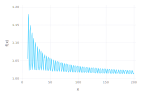

In [58]:
plot( n -> convergence_rate(F,n)[1],10,200)

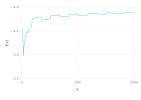

In [59]:
plot(n -> convergence_rate(F,n)[2],10,1000)

Finally, we examine the extrapolated limit $L$. As expected, the graph of the extrapolated limit $L$ approaches its horizontal asymptote far more rapidly than does the graph of $F$.

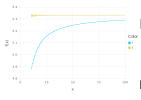

In [60]:
plot([F, n -> convergence_rate(F,n)[3]],10,100)

Here is a crazy example. Let's use the left point rule on $\int_0^1 \frac{1}{\sqrt{1-x}} \mathrm{d} x$. The integrand isn't continuous on $[0,1]$, so this is an improper integral.  Actually, the integrand blows up at $1$, but since the left point rule doesn't evaluate the integrand at the upper limit of integration, the fact that the integrand blows up at $1$ will not cause the left point rule to give an error.

In [61]:
F = n -> left_point_sum(x -> 1/sqrt(1-x), 0.0, 1.0, convert(Int64, floor(n)));

The graph indicates that $\alpha = 1/2$, but the convergence toward $1/2$ is slow and a bit uneven.

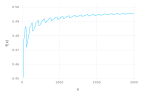

In [62]:
plot(n -> convergence_rate(F,n)[1],30,3000)

And it looks like $A$ approaches $-1$.

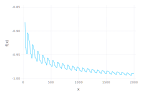

In [63]:
plot(n -> convergence_rate(F,n)[2],30,2000)

The extrapolated limit approaches the true value of the integral _far_ faster than does the unextrapolated limit.

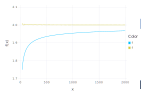

In [64]:
plot([F, n -> convergence_rate(F,n)[3]],30,2000)

Trying examples with a variety of integrands using the left point rule, we would conjecture that $\alpha = 1$ for integrands that are smooth. Accordingly, assuming that
$$
   F_n = L + \frac{A}{n} + \mathrm{O}(1/n^2),
$$
and for some given value of $n$, solving
$$
   F_n = L + \frac{A}{n}  + \mathrm{O}(1/n^2), \\
   F_{2 n} = L + \frac{A}{2 n}  + \mathrm{O}(1/n^2),
$$
gives
$$
   L = 2 F_{2n} - F_n + \mathrm{O}(1/n^2), \\
   A = 2 n (F_n - F_{2n})  + \mathrm{O}(1/n^2).
$$
The extrapolated limit $L$ is a linear combination of $F_{2n}$ and $F_n$ with the weight of $F_{2n}$ twice the magnitude of $F_n.$

The key to proving $F_n = L + \frac{A}{n} + \mathrm{O}(1/n^2)$ is integration by parts. We'll save the proof for another day.




Let's make the same plots for the same integral, but this time let's use the trapezoidal rule. For the left point rule, we found that $\alpha \approx 1$, but for the trapezoidal rule, the graph indicates that $\alpha \approx 2$. A larger value for $\alpha$ is desirable because the term $A / n^\alpha$ decreases more rapidly for large values of $\alpha$. Computationally, the effort for the trapezoidal rule is not greater than it is for the left point rule---accordingly 

In [65]:
F = n ->  trap_pairwise(fn, 2.0, 4.0, convert(Int64, floor(n)));

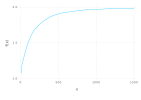

In [66]:
plot( n -> convergence_rate(G,n)[1],10,1500)

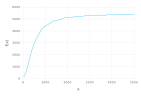

In [67]:
plot(n -> convergence_rate(G,n)[2],10,5000)

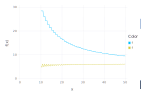

In [68]:
plot([G, n -> convergence_rate(G,n)[3]],10,50)

Let's try all this one more time, but let's choose the definite integral
$$
   \int_{0}^{2 \pi} \sqrt{1 - \frac{9}{25} \sin(x)^2} \, \mathrm{d} x.
$$
Testing the values of $H(10), H(100), H(1000)$, the results look OK

In [69]:
H = n ->  trap_pairwise(x -> sqrt(1 - 0.36 * sin(x)^2), 0.0, 
                 convert(Float64, 2*pi), convert(Int64, floor(n)))

#59 (generic function with 1 method)

In [70]:
H(10), H(100), H(1000)

(5.672338790644484, 5.672333577794897, 5.672333577794897)

But attempting the graph of $\alpha$, the graph is blank. Why is that?

In [71]:
plot( n -> convergence_rate(H,n)[1],10,100)

Plot(...)

In [72]:
Testing this function shows there is a domain error

UndefVarError: UndefVarError: `Testing` not defined

In [73]:
 convergence_rate(H,100)

ErrorException: convergence doesn't appear to be sublinear.

Why does this happen? We determined that
$$
   2^\alpha = \frac{F_{2 n} - F_n}{F_{4 n} - F_{2 n}}
$$
For all real $\alpha$, we have $ 2^\alpha > 0$. If  $ \frac{F_{2 n} - F_n}{F_{4 n} - F_{2 n}} $ happens to be negative, we get a domain error (logarithm base two of a negative number). Our first guess might be that solved our equations incorrectly or that floating point rounding errors have interfered and artificially   made $\frac{F_{2 n} - F_n}{F_{4 n} - F_{2 n}}$ negative.

Actually, neither of these are the culprit. Rather the cause is the guess that
$$
   F_n = L + \frac{1}{n^\alpha} (A + \mathrm{O}(1/n)).
$$
For this integrand and limits of integration, this guess is false, making the calculation of $L,A$, and $\alpha$ rubbish.

Amusingly, for the same integrand but changing the limits of integration from $0$ to $2 \pi$ to $0$ to $63 \pi/32$, all is well and the value of $\alpha$ is again approximately $2$. 


In [74]:
H = n ->  trap_pairwise(x -> sqrt(1 - 0.36 * sin(x)^2), 0.0, convert(Float64, 63*pi/32), convert(Int64, floor(n)));

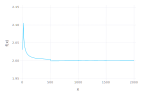

In [75]:
plot( n -> convergence_rate(H,n)[1], 10, 2000)

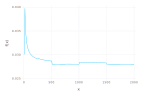

In [76]:
plot( n -> convergence_rate(H,n)[2], 10, 2000)

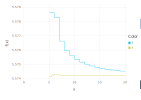

In [77]:
plot([H,n -> convergence_rate(H,n)[3]], 5, 20)

The key to this is the wonderful Euler-Macularin sum formula. Let's save this for another lesson. Suffice it to say that the Euler-Macularin sum formula tells that for a smooth integrand that for any number of equal length subintervals, there is a number $c_2$ such that 
$$
   \int_a^b F(x) \, \mathrm{d} x =  T_n + \frac{c_2}{n^2} + \mathrm{O}(1/n^4),
$$
where $T_n$ is the n-panel trapezoidal rule 

So far we've only used fixed length subintervals. Here is a method that adjusts the subinterval size based on a heuristic. When the second derivative is large, the step size is reduced. The attempt is return a result with an error that is no more than tol. 

The easy way to write this code is to write a recursive function. And with a bit of adjustment, the code can be tail-recursive.  But unlike some languages, Common Lisp, for example, the Julia compiler does not attempt to eliminate tail-recursion. So we'll use explicit iteration, not recursion for our code. But it would be a fun experiment to compare the speed of this code to a tail-recursive version in Julia.

The code needs to find the midpoint of numbers $a$ and $b$.  It uses the straightforward method of $\frac{a+b}{2}$.  Although the method is pretty good, it is possible for $a+b$ to overflow even when the floating point number closest to the true midpoint doesn't overflow. To avoid this potential overflow, the midpoint is sometimes computed as $a + (b-a)/2$. But of course, $b-a$ can overflow when $a$ and $b$ have opposite signs and large magnitudes. 
An alternative to $\frac{a+b}{2} $ that is less likely to overflow is $a/2 + b/2$. This requires one additional division, but for a binary format floating point number, the division is rounding error free and should be superfast.

For all the details in computing the midpoint, see \url{https://hal.archives-ouvertes.fr/file/index/docid/576641/filename/computing-midpoint.pdf}.

The advice to compute the midpoint using $a + (b-a)/2$ is fairly terrible. The well-known textbook _Numerical Analysis_, 9th Edition by Burden and Faires claims that 

  it is possible for $(a + b) / 2$ to return a midpoint that is not even in the interval $[a, b]$

Assuming arithmetic conforms to the IEEE 754 standard, the only way for this to happen is for $a+b$ to overflow or underflow.  So the claim in Burden and Faires is mostly Fear Uncertainty and Doubt.  

Actually, the worst case rounding error for $a + (b-a)/2$ exceeds the worst case rounding error for  $(a+b)/2$. 
Specifically for floating point numbers $a$ and $b$, we have
$$
      \left | (a \oplus b) /2  - (a + b)/2  \right| \leq \varepsilon_m | (a + b)/2 |.
$$
We've assumed a binary format floating point number--that makes division by two error free. The worst case rounding error for $a + (b-a)/2$ is
$$
  \left | a \oplus (b \ominus a)/2 - (a+b)/2 \right| \leq \varepsilon_m | (a + b)/2 | + \varepsilon_m |a-b| /2  + \mathrm{O}(\varepsilon_m^2).
$$
This is larger than the bound for computing $(a+b)/2$. Assuming subnormal numbers, the bounds are more elaborate.


Here is an example where the rounding error for $a + (b-a)/2$ exceeds that of $(a+b)/2$:


In [78]:
xx =  BigInt(1204223703278157824);

In [79]:
yy = BigInt(-1128568076004406528);

The true midpoint is

In [80]:
true_mid = (xx + yy)//2

37827813636875648//1

Convert xx and yy to `Float64` and compute the midpoints

In [81]:
xx = convert(Float64,xx)


1.2042237032781578e18

In [82]:
yy = convert(Float64,yy);

In [83]:
m1 = (xx+yy)/2

3.782781363687565e16

In [84]:
m2 = xx + (yy-xx)/2

3.782781363687578e16

Converting this float to its exact value, the number is $37827813636875776$, but the true value of the mid-point is
$37827813636875648$. The difference of the value computed by $xx + (yy-xx)/2$ and the true value is $128$. For this case, the upper bound for the rounding error is
$$
   2^{-53} \times \left ( |(xx + yy)/2 | + |xx - yy| /2 \right) = \frac{4486082879}{33554432} \approx 134.
$$
So the actual error (128) is just shy of the upper bound (including the big-oh term only very slightly increases the upper bound). The worst case error bounds for  rounding errors aren't just esoteric exercises: _the worst case sometimes almost happens_.

Turns out m1 matches the true midpoint, but m2 doesn't equal the true midpoint

In [85]:
m1 == true_mid

true

In [86]:
m2 == true_mid

false

The midpoint addition in $(a+b)/2$ can overflow, resulting in a midpoint that is `Inf`; for example

In [87]:
(2.0^1023 + 2.0^1023)/2

Inf

So the claim in Burden and Faires is correct. We can avoid this overflow by computing $a/2  + b/2$ instead of $(a + b)/2$; that fixes the problem with the midpoint of $[2^{1023}, 2^{1023}]$

In [88]:
2.0^1023/2 + 2.0^1023/2

8.98846567431158e307

But then we have a problem with underflow:

In [89]:
2.0^-1074 / 2  + 2.0^-1074/2
    

0.0

Here is a function that uses several methods for computing the midpoint; we'll test it using some edge cases.

In [90]:
function midpoint(a,b)
    a/2 + b/2, (a+b)/2, a + (b-a)/2, b + (a-b)/2
end

midpoint (generic function with 1 method)

In [91]:
midpoint(2^-1074, 2^-1073)

(5.0e-324, 1.0e-323, 5.0e-324, 1.0e-323)

In [92]:
midpoint(Inf,Inf)

(Inf, Inf, NaN, NaN)

In [93]:
midpoint(Inf,-Inf)

(NaN, NaN, NaN, NaN)

In [94]:
midpoint(2.0^1023,2.0^1023)

(8.98846567431158e307, Inf, 8.98846567431158e307, 8.98846567431158e307)

In [95]:
midpoint(2.0^1023,-2.0^1023)

(0.0, 0.0, -Inf, Inf)

Finally, here is our adaptive trapezoidal rule code. It could be improved in several ways. Possibly giving the array a type annotation would improve the speed of this code. Possibly the code could use Julia's forward difference package to better compute the second derivatives.  Or maybe we could use the forward difference package to choose the step size without using recursion. Finally, this code uses the guess that the step size must be less than one--there is no particular basis for this guess. Let us save all these possible improvements for another day.

In [96]:
function adaptive_trap(F::Function, a::Number, b::Number, tol::Number)
    I = zero(a)
    cc = zero(a) # for Kahan summation
    S = [[a, b, F(a), F(b)]]
    ep = eps(typeof(a))
    k = 0
    while !isempty(S)
        a,b,fa,fb = pop!(S)
        h = b-a
        c = a/2+b/2
        k += 1
        fc = F(c)
        if h < ep
            error("Unable to approximate integral to requested accuracy.")
        elseif h > 1 # magic number 1
            push!(S,[a,c,fa,fc],[c,b,fc,fb])  
        else 
            i1 = fa/2 + fb/2
            i2 = i1/2 + fc/2
            er = ((fa-fc) + (fb-fc))*h/12 # approx = f''(c)*h/12
            if abs(er) < tol
                y =  (h/3)*(4*i2 - i1) - cc #Kahan summation for I
                t =  I + y
                cc = (t-I)-y
                I = t
             else 
                push!(S,[a,c,fa,fc],[c,b,fc,fb])
            end
        end     
      end 
   I,k
end

adaptive_trap (generic function with 1 method)

The true value of the integral is 1; our code gets it correct.

In [97]:
fn = x -> 1000001*x^1000000;

In [98]:
a,b,tol = (0.0,1.0, 1.0e-12)

(0.0, 1.0, 1.0e-12)

In [99]:
@btime adaptive_trap(fn,a,b,tol)

  2.659 ms (24285 allocations: 2.22 MiB)


(1.0000000000003786, 24281)

I know what you are thinking: doesn't Julia have a standard package for numerical integration?  Yes, it does, and it's very sturdy and gets good results for many problems. But it fails our test giving a value of zero for the integral whose true value is one.

In [100]:
using QuadGK

In [101]:
quadgk(fn,a,b,tol)

(0.0, 0.0)

Here is a recursive version of an adaptive integration rule that I found on github (see \url{http://mth229.github.io/integration.html}). Some comments: 


1. It computes the midpoint of \(a\) and \(b\) using the fairly terrible method of $a + (b-a)/2$. 

2. For each function call, it computes the values of $f(a)$ and $f(b)$ twice. That's wasteful.

3. When the function recurses, the function can be evaluated many times at the same value.  That's wasteful.

4. If _limit_ is initially negative, the code enters an infinite loop. If the initial value of _limit_ is a positive floating point number, the test `limit == 0` might fail, resulting in an infinite loop.

5. The function argument name _limit_ could easily be confused with the mathematical notion of a limit.

6. The code has multiple return statements. This makes the code a bit hard to understand.

7. When limit reaches zero, it's likely that result will be inaccurate, but the code only prints a message and returns a value. Actually, the same error message can be printed many times. That's annoying. An error is more appropriate than a message (suppose the user went for a cup of coffee and missed seeing the warning).

8. The code uses the default values for _isapprox._ Likely the default isn't optimal. Generally, adaptive methods allow the user to specify an error tolerance, not the maximum number of iterations.  Doing so, we'd need to use a user specified error tolerance into the stopping criteria.


Finally, the code is inconsistent in the way it computes the average. To find the midpoint, it uses $a + (b-a)/2$, but the code $(f(a) + f(b))  h/2$  also computes an average, but uses a distinct method.  

In [102]:
function adapt(f, a, b, limit)
    h = b-a
    c = a + (b - a)/2

    a1 = (f(a) + f(b)) * h/2          ## trapezoid
    a2 = (f(a) + 4f(c) + f(b)) * h/6  ## Simpson's parabola

    if isapprox(a1, a2)
        return(a2)
    end

    if limit == 0
        println("limit reached for this interval [$a, $b]")
        return(a2)
    end

    adapt(f, a, c, limit - 1) + adapt(f, c, b, limit-1)
end

adapt (generic function with 1 method)

But for our one test, the function works OK

In [103]:
@btime adapt(fn,a,b,100)

  1.932 s (1 allocation: 16 bytes)


1.0000000000000002

Without doing major revision, let's rework this code. It's a minor thing, but the code computes $f(a)+f(b)$ twice, this code fixes that.

In [104]:
function adapt2(f::Function, a::Number, b::Number, maxIter::Int64)
    adapt2_help(f,a,b,f(a),f(b),maxIter)
end

adapt2 (generic function with 1 method)

In [105]:
function adapt2_help(f::Function, a::Number, b::Number, fa::Number, fb::Number, maxIter::Int64)
    h = b-a
    c = (a+b)/2
    fc = f(c)
    a1 = (fa + fb) * h/2   # trapezoid rule
    a2 = (a1 + 2*h*fc)/3  # parabolic rule

    if isapprox(a1, a2)
        a2
    elseif maxIter < 0
       error("Exceeed maximum number of function calls.")
    else 
        maxIter = div(maxIter,2)
        adapt2_help(f, a, c, fa, fc,  maxIter) + adapt2_help(f, c, b, fc, fb,  maxIter)
    end     
end

adapt2_help (generic function with 1 method)

We have doubled the speed without making major changes.

In [106]:
@btime adapt2(fn,a,b,100)

  509.263 ms (1 allocation: 16 bytes)


1.0000000000000002

But compared to our nonrecursive version, this code is painfully slow. Part of this slowness is likely due to the overly strict condition for stopping the recursion (isapprox(a1, a2)).